In [ ]:
# Install necessary libraries
import json
import pandas as pd
# from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from matplotlib.colors import rgb_to_hsv
from scipy import stats
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

In [2]:
# Mount:
# drive.mount('/content/drive', force_remount = True)

## In this file, I have tried different methods to correct in RGB space.
## Method 0: Fixed White Scaling
## Method 1: Using Polynomial Correction
## Method 2: Using a 3 x 3 Matrix
## Method 3: Using multiple inputs (adding pitch & roll).


In [3]:
# Read json file
def readJsonData(JSON_FILE_PATH):
  data = None
  try:
    with open(JSON_FILE_PATH, 'r') as f:
        data = json.load(f)
    print("✅ JSON file loaded successfully.")

    metadata = data.get('metadata', {})
    print(f"\n--- Session Metadata ---")
    for key, value in metadata.items():
        print(f"{key.ljust(20)}: {value}")

  except FileNotFoundError:
      print(f"❌ ERROR: File not found at path: {JSON_FILE_PATH}")
      print("Please check the file path and ensure Google Drive is correctly mounted.")
  except json.JSONDecodeError:
      print("❌ ERROR: Could not decode JSON. Ensure the file is valid.")
  return data

# Preprocessing
def preprocessData(data):
  flat_data = []

  # Extract metadata for easy merging later
  session_metadata = data.get('metadata', {})
  session_name = session_metadata.get('sessionName', 'Unknown Session')

  # Iterate through each sample (color card)
  for sample in data.get('data', []):
      sample_number = sample.get('sampleNumber')

      # Iterate through each measurement (1 to 10) within that sample
      for capture_index, measurement in enumerate(sample.get('measurements', [])):

          # Create a dictionary for the current row
          row = {
              'session_name': session_name,
              'sample_number': sample_number,
              'capture_index': capture_index, # 0 to 9
              'lighting_condition': session_metadata.get('lightingCondition'),
              'reflective_surface': session_metadata.get('useReflectiveSurface'),

              # Sensor Data
              'pitch': measurement['angles']['pitch'],
              'roll': measurement['angles']['roll'],
          }

          # Extract Color Data (White and Color reticles, three radii each)

          # White Reticle Captures
          for radius in [0, 2, 4]:
              capture_key = f'r{radius}'
              color_data = measurement['white'].get(capture_key, {'r': 0, 'g': 0, 'b': 0})
              row[f'white_r{radius}_R'] = color_data['r']
              row[f'white_r{radius}_G'] = color_data['g']
              row[f'white_r{radius}_B'] = color_data['b']

          # Color Reticle Captures
          for radius in [0, 2, 4]:
              capture_key = f'r{radius}'
              color_data = measurement['color'].get(capture_key, {'r': 0, 'g': 0, 'b': 0})
              row[f'color_r{radius}_R'] = color_data['r']
              row[f'color_r{radius}_G'] = color_data['g']
              row[f'color_r{radius}_B'] = color_data['b']

          flat_data.append(row)

  # Convert the list of dictionaries to a Pandas DataFrame
  df = pd.DataFrame(flat_data)

  print(f"\n✅ Data flattened into DataFrame with {len(df)} rows (Total captures: 24 samples * 10 captures = 240 rows).")
  return df

# ## 3. Initial Review and Visualization

# Display the first few rows and the column types for verification.
def displayDataFrameInfo(df):
  print("\n--- DataFrame Head (First 5 Rows) ---")
  print(df.head())

  print("\n--- DataFrame Information ---")
  print(df.info())

  # ### 3.1 Check Sensor Variability

  # This checks the pitch/roll stability across all 240 measurements.
  print("\n--- Sensor Angle Statistics ---")
  print(df[['pitch', 'roll']].describe())

In [4]:
def combineGroundTruth(df):
  ground_truth_data = [
      {'sample_number': 1,  'label': 'Dark Skin',      'gt__R': 115, 'gt__G': 82,  'gt__B': 69},
      {'sample_number': 2,  'label': 'Light Skin',     'gt__R': 204, 'gt__G': 161, 'gt__B': 141},
      {'sample_number': 3,  'label': 'Blue Sky',       'gt__R': 101, 'gt__G': 134, 'gt__B': 179},
      {'sample_number': 4,  'label': 'Foliage',        'gt__R': 89,  'gt__G': 109, 'gt__B': 61},
      {'sample_number': 5,  'label': 'Blue Flower',    'gt__R': 141, 'gt__G': 137, 'gt__B': 194},
      {'sample_number': 6,  'label': 'Bluish Green',   'gt__R': 132, 'gt__G': 228, 'gt__B': 208},
      {'sample_number': 7,  'label': 'Orange',         'gt__R': 249, 'gt__G': 118, 'gt__B': 35},
      {'sample_number': 8,  'label': 'Purplish Blue',  'gt__R': 80,  'gt__G': 91,  'gt__B': 182},
      {'sample_number': 9,  'label': 'Moderate Red',   'gt__R': 222, 'gt__G': 91,  'gt__B': 125},
      {'sample_number': 10, 'label': 'Purple',         'gt__R': 91,  'gt__G': 63,  'gt__B': 123},
      {'sample_number': 11, 'label': 'Yellow Green',   'gt__R': 173, 'gt__G': 232, 'gt__B': 91},
      {'sample_number': 12, 'label': 'Orange Yellow',  'gt__R': 255, 'gt__G': 164, 'gt__B': 26},
      {'sample_number': 13, 'label': 'Blue',           'gt__R': 44,  'gt__G': 56,  'gt__B': 142},
      {'sample_number': 14, 'label': 'Green',          'gt__R': 74,  'gt__G': 148, 'gt__B': 81},
      {'sample_number': 15, 'label': 'Red',            'gt__R': 179, 'gt__G': 42,  'gt__B': 50},
      {'sample_number': 16, 'label': 'Yellow',         'gt__R': 250, 'gt__G': 226, 'gt__B': 21},
      {'sample_number': 17, 'label': 'Magenta',        'gt__R': 191, 'gt__G': 81,  'gt__B': 160},
      {'sample_number': 18, 'label': 'Cyan',           'gt__R': 6,   'gt__G': 142, 'gt__B': 172},
      {'sample_number': 19, 'label': 'White',          'gt__R': 252, 'gt__G': 252, 'gt__B': 252},
      {'sample_number': 20, 'label': 'Neutral 8',      'gt__R': 230, 'gt__G': 230, 'gt__B': 230},
      {'sample_number': 21, 'label': 'Neutral 6.5',    'gt__R': 200, 'gt__G': 200, 'gt__B': 200},
      {'sample_number': 22, 'label': 'Neutral 5',      'gt__R': 143, 'gt__G': 143, 'gt__B': 142},
      {'sample_number': 23, 'label': 'Neutral 3.5',    'gt__R': 100, 'gt__G': 100, 'gt__B': 100},
      {'sample_number': 24, 'label': 'Black',          'gt__R': 50,  'gt__G': 50,  'gt__B': 50},
  ]
  df_gt = pd.DataFrame(ground_truth_data)
  df = pd.merge(df, df_gt, on='sample_number', how='outer')

  return df, df_gt

def generateFinalDataFrame(df_with_gt_columns):
  # Calculate average color and corrected color values per sample_number
  avg_cols_to_compute = [
      'color_r0_R', 'color_r0_G', 'color_r0_B',
      'correction_r0_R', 'correction_r0_G', 'correction_r0_B',
      'color_r2_R', 'color_r2_G', 'color_r2_B',
      'correction_r2_R', 'correction_r2_G', 'correction_r2_B',
      'color_r4_R', 'color_r4_G', 'color_r4_B',
      'correction_r4_R', 'correction_r4_G', 'correction_r4_B'
  ]
  df_avg = df_with_gt_columns.groupby('sample_number')[avg_cols_to_compute].mean().reset_index()

  # Rename columns to 'avg_...' to clearly distinguish them
  new_avg_columns_map = {col: 'avg_' + col for col in avg_cols_to_compute}
  df_avg = df_avg.rename(columns=new_avg_columns_map)

  # Merge the df (which now has ground truth) with the averaged color data
  df_final_comparison = pd.merge(df_with_gt_columns, df_avg, on='sample_number', how='left')

  return df_final_comparison

In [5]:
jsonFilePath = 'Data/ambient_blue.json'
data = readJsonData(jsonFilePath)
df = preprocessData(data)
df, _ = combineGroundTruth(df)

✅ JSON file loaded successfully.

--- Session Metadata ---
sessionName         : ambient_blue
lightingCondition   : 12
useReflectiveSurface: False
dateTime            : 2025-12-02T22:49:03.937941

✅ Data flattened into DataFrame with 240 rows (Total captures: 24 samples * 10 captures = 240 rows).


## Method 1: Using Polynomial Correction:  
1. correction_r2_R = f1(color_r2_R)
2. correction_r2_G = f2(color_r2_G)
3. correction_r2_B = f3(color_r2_B).
## Our task: Learn the degrees and coefficients of f1, f2, f3.
## Conclusion: Compare with Fixed Scaling Method

In [6]:
def correctByPolynomial_optimizable(meas_r, meas_g, meas_b, coeffs_r, coeffs_g, coeffs_b):
    """Apply polynomials without clipping for optimization"""
    corr_r = np.polyval(coeffs_r[::-1], meas_r) if len(coeffs_r) > 0 else meas_r
    corr_g = np.polyval(coeffs_g[::-1], meas_g) if len(coeffs_g) > 0 else meas_g
    corr_b = np.polyval(coeffs_b[::-1], meas_b) if len(coeffs_b) > 0 else meas_b
    return corr_r, corr_g, corr_b

def calculateSingleChannelLoss(coeffs, measured_values, gt_values, degree):
    def _apply_single_channel_polynomial(meas, ch_coeffs):
        return np.polyval(ch_coeffs[::-1], meas)

    corrected_values = _apply_single_channel_polynomial(measured_values, coeffs)
    # Calculate MSE
    mse = mean_squared_error(gt_values, corrected_values)
    # Add boundary penalty
    boundary_penalty = np.mean((corrected_values < 5) | (corrected_values > 250)) * 1000
    # Add coefficient penalty
    coeff_penalty = 0.001 * np.sum(coeffs**2)

    return mse + boundary_penalty + coeff_penalty

def get_smart_initial_guess_single_channel(measured_series, gt_series, degree):
    """Get reasonable initial coefficients for a single channel using linear regression"""
    X = measured_series.values
    y = gt_series.values

    try:
        if degree == 0:
            coeffs = [np.mean(y)]
        else:
            # Polynomial fit (coeffs are in decreasing order of power)
            poly_coeffs = np.polyfit(X, y, degree)
            coeffs = poly_coeffs[::-1].tolist()  # Convert to our format (lowest degree first)
    except Exception:
        # Fallback: identity mapping coefficients or mean if fit fails
        if degree == 0:
            coeffs = [np.mean(y)]  # Use mean if it fails for degree 0
        elif degree == 1:
            coeffs = [0.0, 1.0]  # Identity: y = x (c0=0, c1=1)
        else:
            coeffs = [0.0] * (degree + 1)
            if degree >= 1: # Set linear term to 1 for higher degrees as a starting point
                coeffs[1] = 1.0
    return np.array(coeffs)

def get_smart_initial_guess(df, degrees):
    """Get reasonable initial coefficients using linear regression"""
    initial_guess = []

    for channel, degree in degrees.items():
        X = df[f'color_r4_{channel}'].values
        y = df[f'gt__{channel}'].values

        # Use polyfit to get reasonable starting point
        try:
            if degree == 0:
                coeffs = [np.mean(y)]
            else:
                poly_coeffs = np.polyfit(X, y, degree)
                coeffs = poly_coeffs[::-1].tolist()  # Convert to our format (lowest degree first)
        except:
            if degree == 0:
                coeffs = [128.0]  # Middle value
            elif degree == 1:
                coeffs = [0.0, 1.0]  # Identity: y = x
            else:
                coeffs = [0.0] * (degree + 1)
                coeffs[1] = 1.0  # Linear term = 1

        initial_guess.extend(coeffs)

    return np.array(initial_guess)

def optimizeSingleChannelCoefficients(df, channel, degree):
    """Optimize coefficients for a single channel"""
    print(f"Optimizing polynomial for {channel} channel with degree {degree}")

    measured_values = df[f'color_r4_{channel}'].values
    gt_values = df[f'gt__{channel}'].values

    # Get smart initial guess
    initial_guess = get_smart_initial_guess_single_channel(df[f'color_r4_{channel}'], df[f'gt__{channel}'], degree)
    print(f"Initial guess for {channel}: {initial_guess}")

    # Define bounds for coefficients
    bounds = [(-1000, 1000)] * (degree + 1)

    # Use a partial function to pass fixed arguments to the loss function
    loss_func = partial(calculateSingleChannelLoss, measured_values=measured_values, gt_values=gt_values, degree=degree)

    # Optimize
    result = minimize(
        loss_func,
        initial_guess,
        method='L-BFGS-B',
        bounds=bounds,
        options={'maxiter': 1000, 'ftol': 1e-8}
    )

    optimal_coeffs = result.x

    dummy_meas = np.zeros_like(measured_values)

    if channel == 'R':
        final_corr_r, _, _ = correctByPolynomial_optimizable(measured_values, dummy_meas, dummy_meas, optimal_coeffs, np.array([0.0]), np.array([0.0]))
        final_corrected_values = np.clip(final_corr_r, 0, 255).astype(int)
    elif channel == 'G':
        _, final_corr_g, _ = correctByPolynomial_optimizable(dummy_meas, measured_values, dummy_meas, np.array([0.0]), optimal_coeffs, np.array([0.0]))
        final_corrected_values = np.clip(final_corr_g, 0, 255).astype(int)
    elif channel == 'B':
        _, _, final_corr_b = correctByPolynomial_optimizable(dummy_meas, dummy_meas, measured_values, np.array([0.0]), np.array([0.0]), optimal_coeffs)
        final_corrected_values = np.clip(final_corr_b, 0, 255).astype(int)
    else:
        raise ValueError("Invalid channel")

    final_mse = mean_squared_error(gt_values, final_corrected_values)

    print(f"Final MSE for {channel}: {final_mse:.2f}")
    print(f"{channel} coefficients: {optimal_coeffs}")
    print(f"Value ranges - {channel}: [{final_corrected_values.min()}, {final_corrected_values.max()}]")

    return {
        'coeffs': optimal_coeffs.tolist(),
        'mse': final_mse
    }

def calculateUnifiedLoss(all_coeffs, df, degrees):
    """
    Calculate loss for all channels simultaneously
    with penalty for boundary solutions
    """
    # Split coefficients for each channel
    n_r = degrees['R'] + 1
    n_g = degrees['G'] + 1
    n_b = degrees['B'] + 1

    coeffs_r = all_coeffs[:n_r]
    coeffs_g = all_coeffs[n_r:n_r+n_g]
    coeffs_b = all_coeffs[n_r+n_g:]

    # Get corrected values
    corr_r, corr_g, corr_b = correctByPolynomial_optimizable(
        df['color_r4_R'].values,
        df['color_r4_G'].values,
        df['color_r4_B'].values,
        coeffs_r, coeffs_g, coeffs_b
    )

    # Calculate MSE for each channel
    mse_r = mean_squared_error(df['gt__R'].values, corr_r)
    mse_g = mean_squared_error(df['gt__G'].values, corr_g)
    mse_b = mean_squared_error(df['gt__B'].values, corr_b)

    # Total MSE (weighted equally)
    total_mse = (mse_r + mse_g + mse_b) / 3.0

    # **CRITICAL: Add penalty for boundary solutions**
    boundary_penalty = 0.0

    # Penalize values near 0 or 255
    penalty_r = np.mean((corr_r < 5) | (corr_r > 250)) * 1000
    penalty_g = np.mean((corr_g < 5) | (corr_g > 250)) * 1000
    penalty_b = np.mean((corr_b < 5) | (corr_b > 250)) * 1000

    boundary_penalty = penalty_r + penalty_g + penalty_b

    # Penalize extreme coefficients to prevent overfitting
    coeff_penalty = 0.001 * (np.sum(coeffs_r**2) + np.sum(coeffs_g**2) + np.sum(coeffs_b**2))

    return total_mse + boundary_penalty + coeff_penalty

def optimizeUnifiedCoefficients(df, degrees):
    """Optimize all channels together with the same degree"""
    print(f"Optimizing unified polynomials with degrees R:{degrees['R']}, G:{degrees['G']}, B:{degrees['B']}")

    # Get smart initial guess
    initial_guess = get_smart_initial_guess(df, degrees)

    print(f"Initial guess: {initial_guess}")

    # Define bounds to prevent extreme coefficients
    bounds = []
    total_coeffs = (degrees['R'] + 1) + (degrees['G'] + 1) + (degrees['B'] + 1)

    # Reasonable bounds for coefficients
    for i in range(total_coeffs):
        # Allow some flexibility but prevent extreme values
        bounds.append((-1000, 1000))

    # Optimize with constraints
    result = minimize(
        calculateUnifiedLoss,
        initial_guess,
        args=(df, degrees),
        method='L-BFGS-B',  # Handles bounds
        bounds=bounds,
        options={'maxiter': 1000, 'ftol': 1e-8}
    )

    # Split the optimized coefficients
    n_r = degrees['R'] + 1
    n_g = degrees['G'] + 1
    n_b = degrees['B'] + 1

    optimal_coeffs_r = result.x[:n_r]
    optimal_coeffs_g = result.x[n_r:n_r+n_g]
    optimal_coeffs_b = result.x[n_r+n_g:]

    # Calculate final performance
    final_r, final_g, final_b = correctByPolynomial_optimizable(
        df['color_r4_R'].values,
        df['color_r4_G'].values,
        df['color_r4_B'].values,
        optimal_coeffs_r, optimal_coeffs_g, optimal_coeffs_b
    )

    # Apply clipping only for final output
    final_r = np.clip(final_r, 0, 255).astype(int)
    final_g = np.clip(final_g, 0, 255).astype(int)
    final_b = np.clip(final_b, 0, 255).astype(int)

    mse_r = mean_squared_error(df['gt__R'].values, final_r)
    mse_g = mean_squared_error(df['gt__G'].values, final_g)
    mse_b = mean_squared_error(df['gt__B'].values, final_b)
    avg_mse = (mse_r + mse_g + mse_b) / 3.0

    print(f"Final MSE - R: {mse_r:.2f}, G: {mse_g:.2f}, B: {mse_b:.2f}, Avg: {avg_mse:.2f}")
    print(f"R coefficients: {optimal_coeffs_r}")
    print(f"G coefficients: {optimal_coeffs_g}")
    print(f"B coefficients: {optimal_coeffs_b}")

    # Check value ranges
    print(f"Value ranges - R: [{final_r.min()}, {final_r.max()}], G: [{final_g.min()}, {final_g.max()}], B: [{final_b.min()}, {final_b.max()}]")

    return {
        'R': optimal_coeffs_r.tolist(),
        'G': optimal_coeffs_g.tolist(),
        'B': optimal_coeffs_b.tolist(),
        'mse': avg_mse,
        'mse_r': mse_r,
        'mse_g': mse_g,
        'mse_b': mse_b
    }

In [7]:
def findBestPolynomials_individual(df, max_degree=10):
    """
    Find the best polynomial degrees for each channel individually
    Only tests max_degree combinations per channel (30 total for max_degree=10)
    """
    print(f"Optimizing channels individually (max {max_degree} degrees per channel)")

    best_results = {}
    best_degrees = {}

    # Optimize each channel separately
    for channel in ['R', 'G', 'B']:
        print(f"\n{'='*50}")
        print(f"OPTIMIZING CHANNEL {channel}")
        print(f"{'='*50}")

        channel_best_result = None
        channel_best_degree = None

        # Try different degrees for this channel only
        for degree in range(1, max_degree + 1):
            print(f"\nTesting degree {degree} for channel {channel}")

            try:
                # Use your original single-channel optimization
                result = optimizeSingleChannel(df, channel, degree)

                if channel_best_result is None or result['mse'] < channel_best_result['mse']:
                    channel_best_result = result
                    channel_best_degree = degree
                    print(f"*** NEW BEST for {channel}: MSE = {result['mse']:.4f} at degree {degree} ***")
                else:
                    print(f"No improvement. Current best MSE: {channel_best_result['mse']:.4f}")

            except Exception as e:
                print(f"Failed for {channel} degree {degree}: {e}")
                continue

        # Store the best result for this channel
        best_results[channel] = channel_best_result
        best_degrees[channel] = channel_best_degree

        print(f"\n--- BEST RESULT FOR CHANNEL {channel} ---")
        print(f"Best degree: {channel_best_degree}")
        print(f"Best MSE: {channel_best_result['mse']:.4f}")
        print(f"Best coefficients: {channel_best_result['coefficients']}")

    # Combine results
    final_result = {
        'R': best_results['R']['coefficients'],
        'G': best_results['G']['coefficients'],
        'B': best_results['B']['coefficients'],
        'mse_r': best_results['R']['mse'],
        'mse_g': best_results['G']['mse'],
        'mse_b': best_results['B']['mse'],
        'avg_mse': (best_results['R']['mse'] + best_results['G']['mse'] + best_results['B']['mse']) / 3.0
    }

    print(f"\n{'='*60}")
    print("FINAL INDIVIDUAL OPTIMIZATION RESULTS:")
    print(f"Best degrees - R:{best_degrees['R']}, G:{best_degrees['G']}, B:{best_degrees['B']}")
    print(f"Channel MSE - R:{final_result['mse_r']:.4f}, G:{final_result['mse_g']:.4f}, B:{final_result['mse_b']:.4f}")
    print(f"Average MSE: {final_result['avg_mse']:.4f}")
    print(f"R coefficients: {final_result['R']}")
    print(f"G coefficients: {final_result['G']}")
    print(f"B coefficients: {final_result['B']}")
    print(f"{'='*60}")

    return final_result, best_degrees

def optimizeSingleChannel(df, channel, degree):
    """
    Optimize polynomial for a single channel
    This should be your original single-channel optimization function
    """
    # Extract data for this specific channel
    meas_col = f'color_r4_{channel}'
    gt_col = f'gt__{channel}'

    X_data = df[meas_col].values
    y_true = df[gt_col].values

    # Number of coefficients for this degree
    n_coeffs = degree + 1

    # Smart initial guess using polyfit
    try:
        initial_guess = np.polyfit(X_data, y_true, degree)[::-1]  # Reverse for our format
    except:
        # Fallback to identity mapping
        initial_guess = [0.0] * n_coeffs
        if degree >= 1:
            initial_guess[1] = 1.0  # Linear term = 1

    # Define bounds to prevent extreme coefficients
    bounds = [(-1000, 1000) for _ in range(n_coeffs)]

    # Optimize this single channel
    result = minimize(
        calculateSingleChannelLoss,
        initial_guess,
        args=(X_data, y_true, degree),
        method='L-BFGS-B',
        bounds=bounds,
        options={'maxiter': 500, 'ftol': 1e-8}
    )

    # Get final corrected values
    optimal_coeffs = result.x
    y_pred = evaluatePolynomial(X_data, optimal_coeffs, degree)

    # Apply clipping for final evaluation
    y_pred_clipped = np.clip(y_pred, 0, 255).astype(int)
    final_mse = mean_squared_error(y_true, y_pred_clipped)

    return {
        'coefficients': optimal_coeffs.tolist(),
        'mse': final_mse,
        'success': result.success
    }

def calculateSingleChannelLoss(coeffs, X_data, y_true, degree):
    """Calculate loss for a single channel"""
    y_pred = evaluatePolynomial(X_data, coeffs, degree)

    # MSE
    mse = np.mean((y_pred - y_true) ** 2)

    # Add penalty for boundary values to prevent the 0/255 problem
    boundary_penalty = np.mean((y_pred < 5) | (y_pred > 250)) * 1000

    # Regularization to prevent overfitting
    reg_penalty = 0.001 * np.sum(np.array(coeffs) ** 2)

    return mse + boundary_penalty + reg_penalty

def evaluatePolynomial(X, coeffs, degree):
    """Evaluate polynomial without clipping"""
    y_pred = np.zeros_like(X, dtype=float)
    for k in range(degree + 1):
        y_pred += coeffs[k] * (X ** k)
    return y_pred

# Run the individual optimization
print("Starting individual channel optimization...")
best_result, best_degrees = findBestPolynomials_individual(df, max_degree=10)

# Extract the final coefficients
best_coeffs_R = best_result['R']
best_coeffs_G = best_result['G']
best_coeffs_B = best_result['B']

print(f"\nFinal coefficients ready for use:")
print(f"R: {best_coeffs_R}")
print(f"G: {best_coeffs_G}")
print(f"B: {best_coeffs_B}")

Starting individual channel optimization...
Optimizing channels individually (max 10 degrees per channel)

OPTIMIZING CHANNEL R

Testing degree 1 for channel R
*** NEW BEST for R: MSE = 3365.7125 at degree 1 ***

Testing degree 2 for channel R
*** NEW BEST for R: MSE = 3364.1917 at degree 2 ***

Testing degree 3 for channel R
*** NEW BEST for R: MSE = 3337.3375 at degree 3 ***

Testing degree 4 for channel R
*** NEW BEST for R: MSE = 3319.1708 at degree 4 ***

Testing degree 5 for channel R
*** NEW BEST for R: MSE = 3132.5042 at degree 5 ***

Testing degree 6 for channel R
*** NEW BEST for R: MSE = 3109.2333 at degree 6 ***

Testing degree 7 for channel R
*** NEW BEST for R: MSE = 2991.0542 at degree 7 ***

Testing degree 8 for channel R
*** NEW BEST for R: MSE = 2947.6333 at degree 8 ***

Testing degree 9 for channel R
No improvement. Current best MSE: 2947.6333

Testing degree 10 for channel R
No improvement. Current best MSE: 2947.6333

--- BEST RESULT FOR CHANNEL R ---
Best degree:

In [8]:
def validate_correction(df, coeffs_r, coeffs_g, coeffs_b):
    """Validate the correction and show results"""
    corr_r, corr_g, corr_b = correctByPolynomial_optimizable(
        df['color_r4_R'].values,
        df['color_r4_G'].values,
        df['color_r4_B'].values,
        coeffs_r, coeffs_g, coeffs_b
    )

    # Apply clipping for final output
    corr_r = np.clip(corr_r, 0, 255).astype(int)
    corr_g = np.clip(corr_g, 0, 255).astype(int)
    corr_b = np.clip(corr_b, 0, 255).astype(int)

    print("Validation Results:")
    print(f"R range: [{corr_r.min()}, {corr_r.max()}] -> Target: ~[{df['gt__R'].min()}, {df['gt__R'].max()}]")
    print(f"G range: [{corr_g.min()}, {corr_g.max()}] -> Target: ~[{df['gt__G'].min()}, {df['gt__G'].max()}]")
    print(f"B range: [{corr_b.min()}, {corr_b.max()}] -> Target: ~[{df['gt__B'].min()}, {df['gt__B'].max()}]")

    # Check if we have the boundary problem
    if corr_r.min() == 0 and corr_r.max() == 255:
        print("WARNING: R channel has boundary values!")
    if corr_g.min() == 0 and corr_g.max() == 255:
        print("WARNING: G channel has boundary values!")
    if corr_b.min() == 0 and corr_b.max() == 255:
        print("WARNING: B channel has boundary values!")

    return corr_r, corr_g, corr_b

# Validate the results
final_r, final_g, final_b = validate_correction(df, best_coeffs_R, best_coeffs_G, best_coeffs_B)

Validation Results:
R range: [55, 228] -> Target: ~[6, 255]
G range: [50, 247] -> Target: ~[42, 252]
B range: [44, 253] -> Target: ~[21, 252]


In [9]:
def correctByFixedWhiteScaling(ref_r, ref_g, ref_b, meas_r, meas_g, meas_b):
  # Apply scaling correction based on a fixed white reference
  scale_r = 255.0 / (ref_r if ref_r > 0 else 1.0)
  scale_g = 255.0 / (ref_g if ref_g > 0 else 1.0)
  scale_b = 255.0 / (ref_b if ref_b > 0 else 1.0)

  corr_r = np.clip(meas_r * scale_r, 0, 255).astype(int)
  corr_g = np.clip(meas_g * scale_g, 0, 255).astype(int)
  corr_b = np.clip(meas_b * scale_b, 0, 255).astype(int)
  return corr_r, corr_g, corr_b

def correctByPolynomial(meas_val, coeffs):
  corr_val = np.polyval(coeffs[::-1], meas_val)
  return corr_val

from functools import partial

# This function will be passed to df.apply and dispatches to the correct method
def apply_correction_dispatcher(row, color_prefix, radius, correction_type, coeffs_R=None, coeffs_G=None, coeffs_B=None, ref_white_R=None, ref_white_G=None, ref_white_B=None):
    meas_r = row[f'{color_prefix}_R']
    meas_g = row[f'{color_prefix}_G']
    meas_b = row[f'{color_prefix}_B']

    if correction_type == 'white_scaling':
        # Use the fixed white reference for scaling
        ref_r = 184.5 # Default from original apply_correction
        ref_g = 171.8
        ref_b = 146.5
        corr_r, corr_g, corr_b = correctByFixedWhiteScaling(ref_r, ref_g, ref_b, meas_r, meas_g, meas_b)
    elif correction_type == 'polynomial':
        corr_r = correctByPolynomial(meas_r, coeffs_R)
        corr_g = correctByPolynomial(meas_g, coeffs_G)
        corr_b = correctByPolynomial(meas_b, coeffs_B)
        # Apply clipping here as correctByPolynomial doesn't do it
        corr_r = np.clip(corr_r, 0, 255).astype(int)
        corr_g = np.clip(corr_g, 0, 255).astype(int)
        corr_b = np.clip(corr_b, 0, 255).astype(int)
    else:
        raise ValueError(f"Unknown correction_type: {correction_type}")

    return pd.Series([corr_r, corr_g, corr_b])

# Main function to apply corrections to DataFrame
def correctRGB(df, correction_type, coeffs_R=None, coeffs_G=None, coeffs_B=None):
  # partial the dispatcher so we can pass the specific correction_type and coeffs
  partial_apply = partial(
      apply_correction_dispatcher,
      correction_type=correction_type,
      coeffs_R=coeffs_R,
      coeffs_G=coeffs_G,
      coeffs_B=coeffs_B
  )

  df[['correction_r0_R', 'correction_r0_G', 'correction_r0_B']] = df.apply(
      lambda row: partial_apply(row, 'color_r0', radius = 0), axis=1
  )
  df[['correction_r2_R', 'correction_r2_G', 'correction_r2_B']] = df.apply(
      lambda row: partial_apply(row, 'color_r2', radius = 2), axis=1
  )
  df[['correction_r4_R', 'correction_r4_G', 'correction_r4_B']] = df.apply(
      lambda row: partial_apply(row, 'color_r4', radius = 4), axis=1
  )

print("Correction functions redefined for flexibility.")

Correction functions redefined for flexibility.


In [10]:
correctRGB(df, correction_type='polynomial', coeffs_R=best_coeffs_R, coeffs_G=best_coeffs_G, coeffs_B=best_coeffs_B)

def rgb_to_hsv_wrapper(r, g, b):
    # Normalize RGB values to [0, 1]
    rgb_normalized = np.array([r, g, b]) / 255.0
    h, s, v = rgb_to_hsv(rgb_normalized)
    return pd.Series([h, s, v])

# Convert original RGB values to HSV and add to DataFrame
rgb_column_sets = [
    ('white', 'r0'), ('white', 'r2'), ('white', 'r4'),
    ('color', 'r0'), ('color', 'r2'), ('color', 'r4'),
    ('gt', '') # This entry needs to be fixed to match the new gt__R naming
]

for prefix, radius in rgb_column_sets:
    # Special handling for ground truth to match the double underscore naming
    if prefix == 'gt':
        r_col, g_col, b_col = 'gt__R', 'gt__G', 'gt__B'
        h_col, s_col, v_col = 'gt__H', 'gt__S', 'gt__V'
    else:
        r_col, g_col, b_col = f'{prefix}_{radius}_R', f'{prefix}_{radius}_G', f'{prefix}_{radius}_B'
        h_col, s_col, v_col = f'{prefix}_{radius}_H', f'{prefix}_{radius}_S', f'{prefix}_{radius}_V'

    df[[h_col, s_col, v_col]] = df.apply(
        lambda row: rgb_to_hsv_wrapper(row[r_col], row[g_col], row[b_col]),
        axis=1, result_type='expand'
    )
displayDataFrameInfo(df)


--- DataFrame Head (First 5 Rows) ---
   session_name  sample_number  capture_index  lighting_condition  \
0  ambient_blue              1              0                  12   
1  ambient_blue              1              1                  12   
2  ambient_blue              1              2                  12   
3  ambient_blue              1              3                  12   
4  ambient_blue              1              4                  12   

   reflective_surface     pitch      roll  white_r0_R  white_r0_G  white_r0_B  \
0               False  6.006072  1.265740          50          51         239   
1               False  5.379371  1.197400          50          51         240   
2               False  5.231365  1.273735          49          50         238   
3               False  4.681344  0.850710          50          49         239   
4               False  3.180701  0.827603          49          50         238   

   ...  color_r0_V  color_r2_H  color_r2_S  color_r2_V  col

In [11]:
df_final_comparison = generateFinalDataFrame(df)
displayDataFrameInfo(df_final_comparison)


--- DataFrame Head (First 5 Rows) ---
   session_name  sample_number  capture_index  lighting_condition  \
0  ambient_blue              1              0                  12   
1  ambient_blue              1              1                  12   
2  ambient_blue              1              2                  12   
3  ambient_blue              1              3                  12   
4  ambient_blue              1              4                  12   

   reflective_surface     pitch      roll  white_r0_R  white_r0_G  white_r0_B  \
0               False  6.006072  1.265740          50          51         239   
1               False  5.379371  1.197400          50          51         240   
2               False  5.231365  1.273735          49          50         238   
3               False  4.681344  0.850710          50          49         239   
4               False  3.180701  0.827603          49          50         238   

   ...  avg_color_r2_B  avg_correction_r2_R  avg_correction

In [12]:
df_final_comparison[['gt__R', 'gt__G', 'gt__B']]

,gt__R,gt__G,gt__B
0,115,82,69
1,115,82,69
2,115,82,69
3,115,82,69
4,115,82,69
...,...,...,...
235,50,50,50
236,50,50,50
237,50,50,50
238,50,50,50


In [13]:
df_final_comparison[['color_r4_R', 'color_r4_G', 'color_r4_B']]

,color_r4_R,color_r4_G,color_r4_B
0,11,7,57
1,12,7,57
2,11,7,57
3,11,7,57
4,11,7,57
...,...,...,...
235,5,2,29
236,5,2,29
237,5,2,29
238,7,3,38


In [14]:
df_final_comparison[['correction_r4_R', 'correction_r4_G', 'correction_r4_B']]

,correction_r4_R,correction_r4_G,correction_r4_B
0,122,157,79
1,122,157,79
2,122,157,79
3,122,157,79
4,122,157,79
...,...,...,...
235,55,55,47
236,55,55,47
237,55,55,47
238,72,88,45


In [15]:
a_sum_sq = ((df_final_comparison['gt__R'] - df_final_comparison['correction_r4_R']) ** 2).sum()
b_sum_sq = ((df_final_comparison['gt__G'] - df_final_comparison['correction_r4_G']) ** 2).sum()
c_sum_sq = ((df_final_comparison['gt__B'] - df_final_comparison['correction_r4_B']) ** 2).sum()

print(f"Sum of (a1 - a2)^2: {a_sum_sq}")
print(f"Sum of (b1 - b2)^2: {b_sum_sq}")
print(f"Sum of (c1 - c2)^2: {c_sum_sq}")

Sum of (a1 - a2)^2: 707432
Sum of (b1 - b2)^2: 362054
Sum of (c1 - c2)^2: 54663


In [16]:
def rgb_to_hsv_overload(r, g, b):
    # Normalize R, G, B values to the range 0-1
    r_norm, g_norm, b_norm = map(lambda x: x/255, (r,g,b))

    # Calculate C_max, C_min, and delta
    C_max, C_min = max(r_norm, g_norm, b_norm), min(r_norm, g_norm, b_norm)
    delta = C_max - C_min

    # Calculate Hue (H)
    h = 0
    if delta > 0:
      if C_max == r_norm: h = 60 * (((g_norm - b_norm) / delta) % 6)
      elif C_max == g_norm: h = 60 * (((b_norm - r_norm) / delta) + 2)
      elif C_max == b_norm: h = 60 * (((r_norm - g_norm) / delta) + 4)

    # Ensure H is in the range [0, 360)
    if h < 0: h += 360

    # Calculate Saturation (S)
    s = delta / C_max if C_max > 0 else 0

    # Calculate Value (V)
    v = C_max

    return h, s, v

def rgb_to_hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(int(r), int(g), int(b))

In [17]:
def plot_comparison_grid(df_final_comparison, radius, rows=6, cols=4):
    df_plot = df_final_comparison.drop_duplicates(subset=['sample_number']).reset_index(drop=True)

    num_samples = len(df_plot)
    print(f"Plotting {num_samples} unique samples for radius r{radius}.")

    if num_samples == 0:
        print(f"No data to plot for radius r{radius}.")
        return

    if num_samples != rows * cols:
        print(f"Warning: Number of samples ({num_samples}) does not match grid size ({rows}x{cols}). Plotting up to {rows * cols} samples.")

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
    axes = axes.flatten()

    for i, row_data in df_plot.iterrows():
        if i >= len(axes):
            break # Stop if we run out of subplots

        # Dynamically extract columns based on radius, now using the 'avg_' prefix for comparison plots
        uncorr_r, uncorr_g, uncorr_b = row_data[f'avg_color_r{radius}_R'], row_data[f'avg_color_r{radius}_G'], row_data[f'avg_color_r{radius}_B']
        corr_r, corr_g, corr_b = row_data[f'avg_correction_r{radius}_R'], row_data[f'avg_correction_r{radius}_G'], row_data[f'avg_correction_r{radius}_B']

        # Ground Truth remains the same
        gt_r, gt_g, gt_b = row_data['gt__R'], row_data['gt__G'], row_data['gt__B']
        label = row_data['label']
        sample_number = row_data['sample_number']

        # Normalize RGB values to 0-1 for imshow
        gt_color_norm = np.array([gt_r, gt_g, gt_b]) / 255.0
        uncorr_color_norm = np.array([uncorr_r, uncorr_g, uncorr_b]) / 255.0
        corr_color_norm = np.array([corr_r, corr_g, corr_b]) / 255.0

        # Create the 100x100 image array for the 3-part comparison
        image = np.zeros((100, 100, 3))

        # Lower half (Ground Truth)
        image[50:100, 0:100] = gt_color_norm
        # Upper-left quarter (Uncorrected)
        image[0:50, 0:50] = uncorr_color_norm
        # Upper-right quarter (Corrected)
        image[0:50, 50:100] = corr_color_norm

        ax = axes[i]
        ax.imshow(image)

        # Add hex labels
        ax.text(25, 75, rgb_to_hex(gt_r, gt_g, gt_b), color='black' if np.mean(gt_color_norm) > 0.5 else 'white',
                ha='center', va='center', fontsize=7, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
        ax.text(25, 25, rgb_to_hex(uncorr_r, uncorr_g, uncorr_b), color='black' if np.mean(uncorr_color_norm) > 0.5 else 'white',
                ha='center', va='center', fontsize=7, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
        ax.text(75, 25, rgb_to_hex(corr_r, corr_g, corr_b), color='black' if np.mean(corr_color_norm) > 0.5 else 'white',
                ha='center', va='center', fontsize=7, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

        ax.set_title(f"#{int(sample_number)}: {label}", fontsize=9)
        ax.set_xticks([])
        ax.set_yticks([])

    # Hide any unused subplots
    for j in range(num_samples, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(f'R{radius} Comparison (Averaged): Ground Truth vs. Uncorrected vs. Corrected', y=0.98, fontsize=16)
    if radius == 0: plt.savefig('Correction comparison with ground truth.png')
    plt.show()

def plotAllRadius(df_final_comparison):
  for radius in [0, 2, 4]:
    plot_comparison_grid(df_final_comparison, radius)

Plotting 24 unique samples for radius r0.


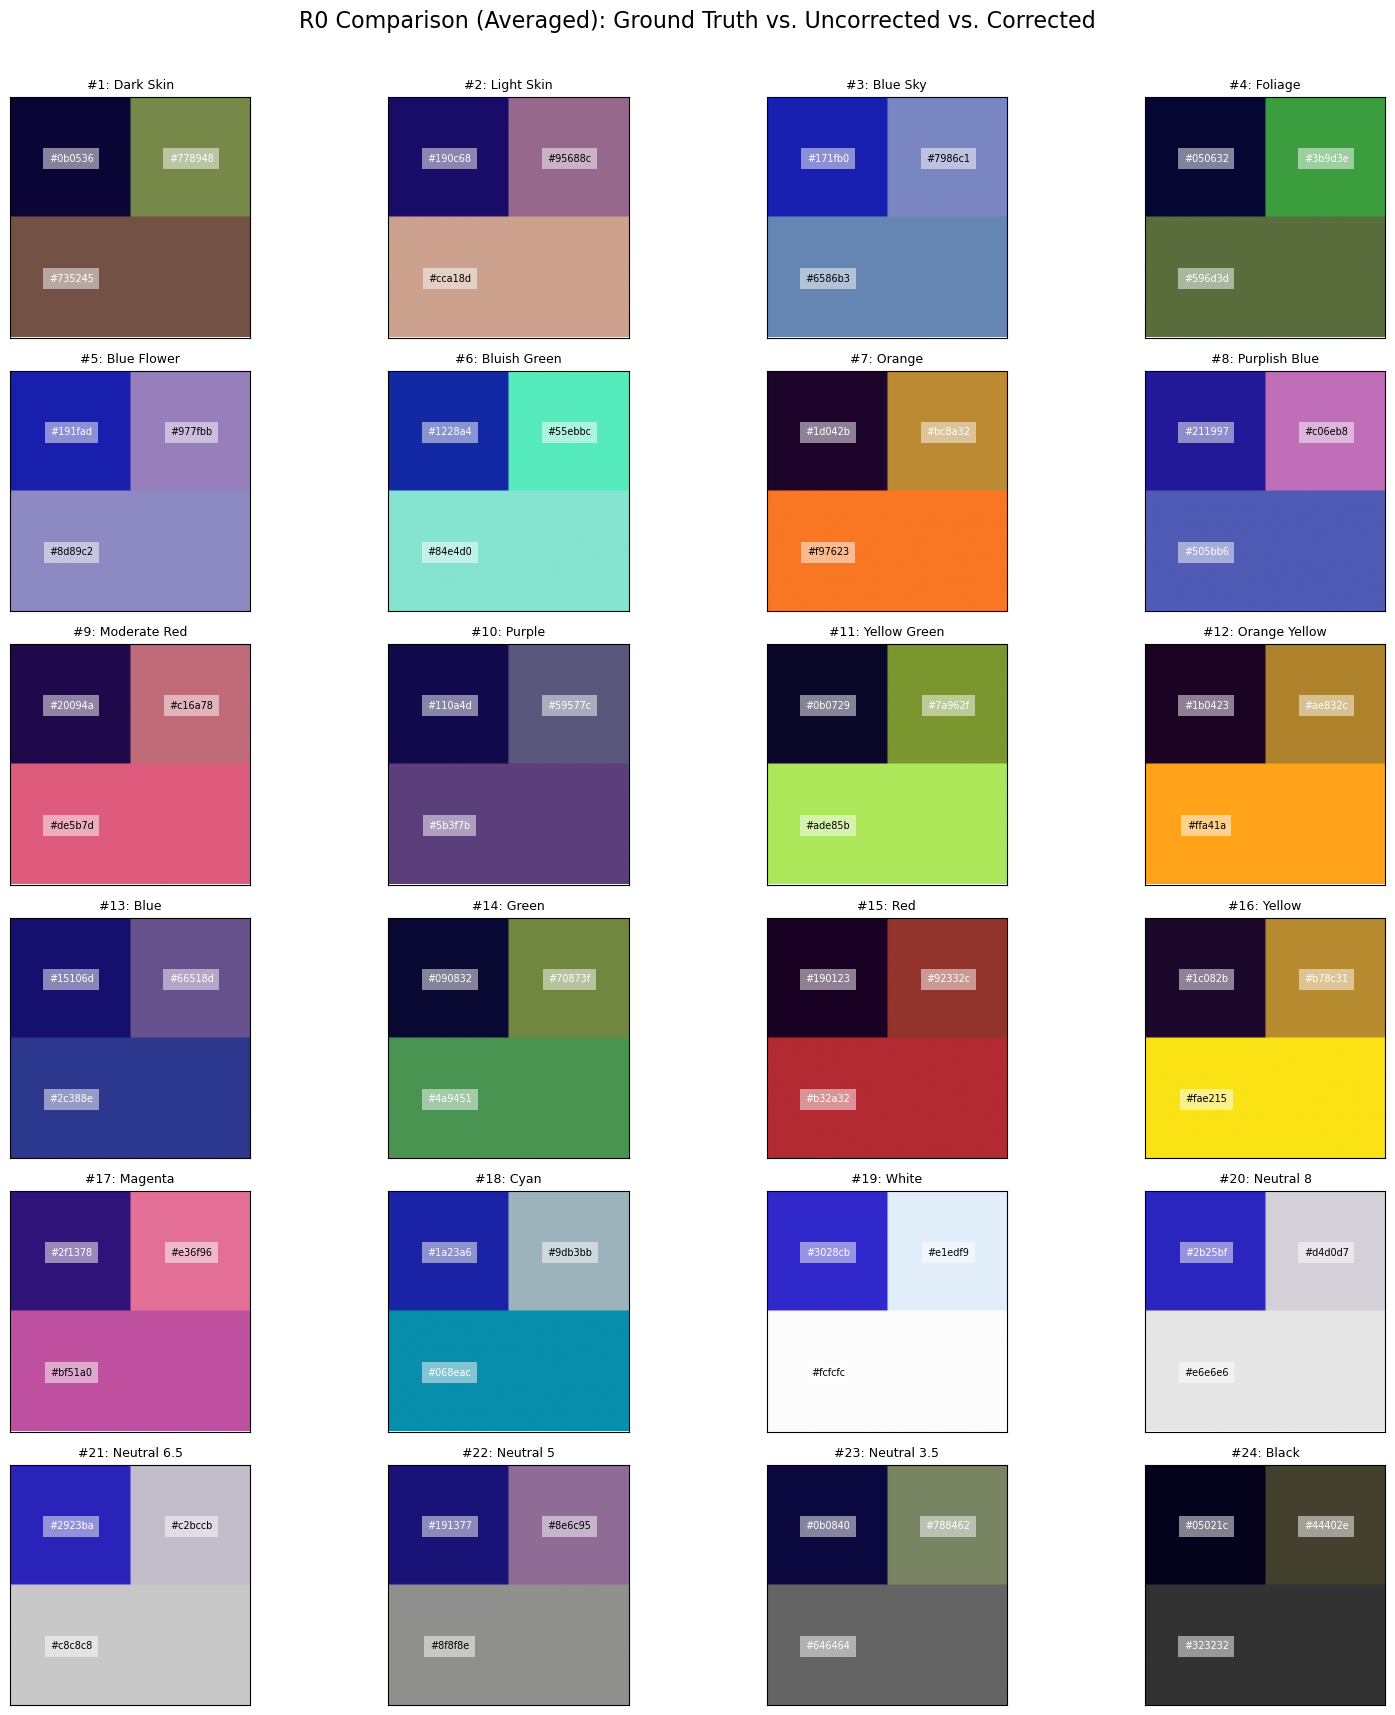

Plotting 24 unique samples for radius r2.


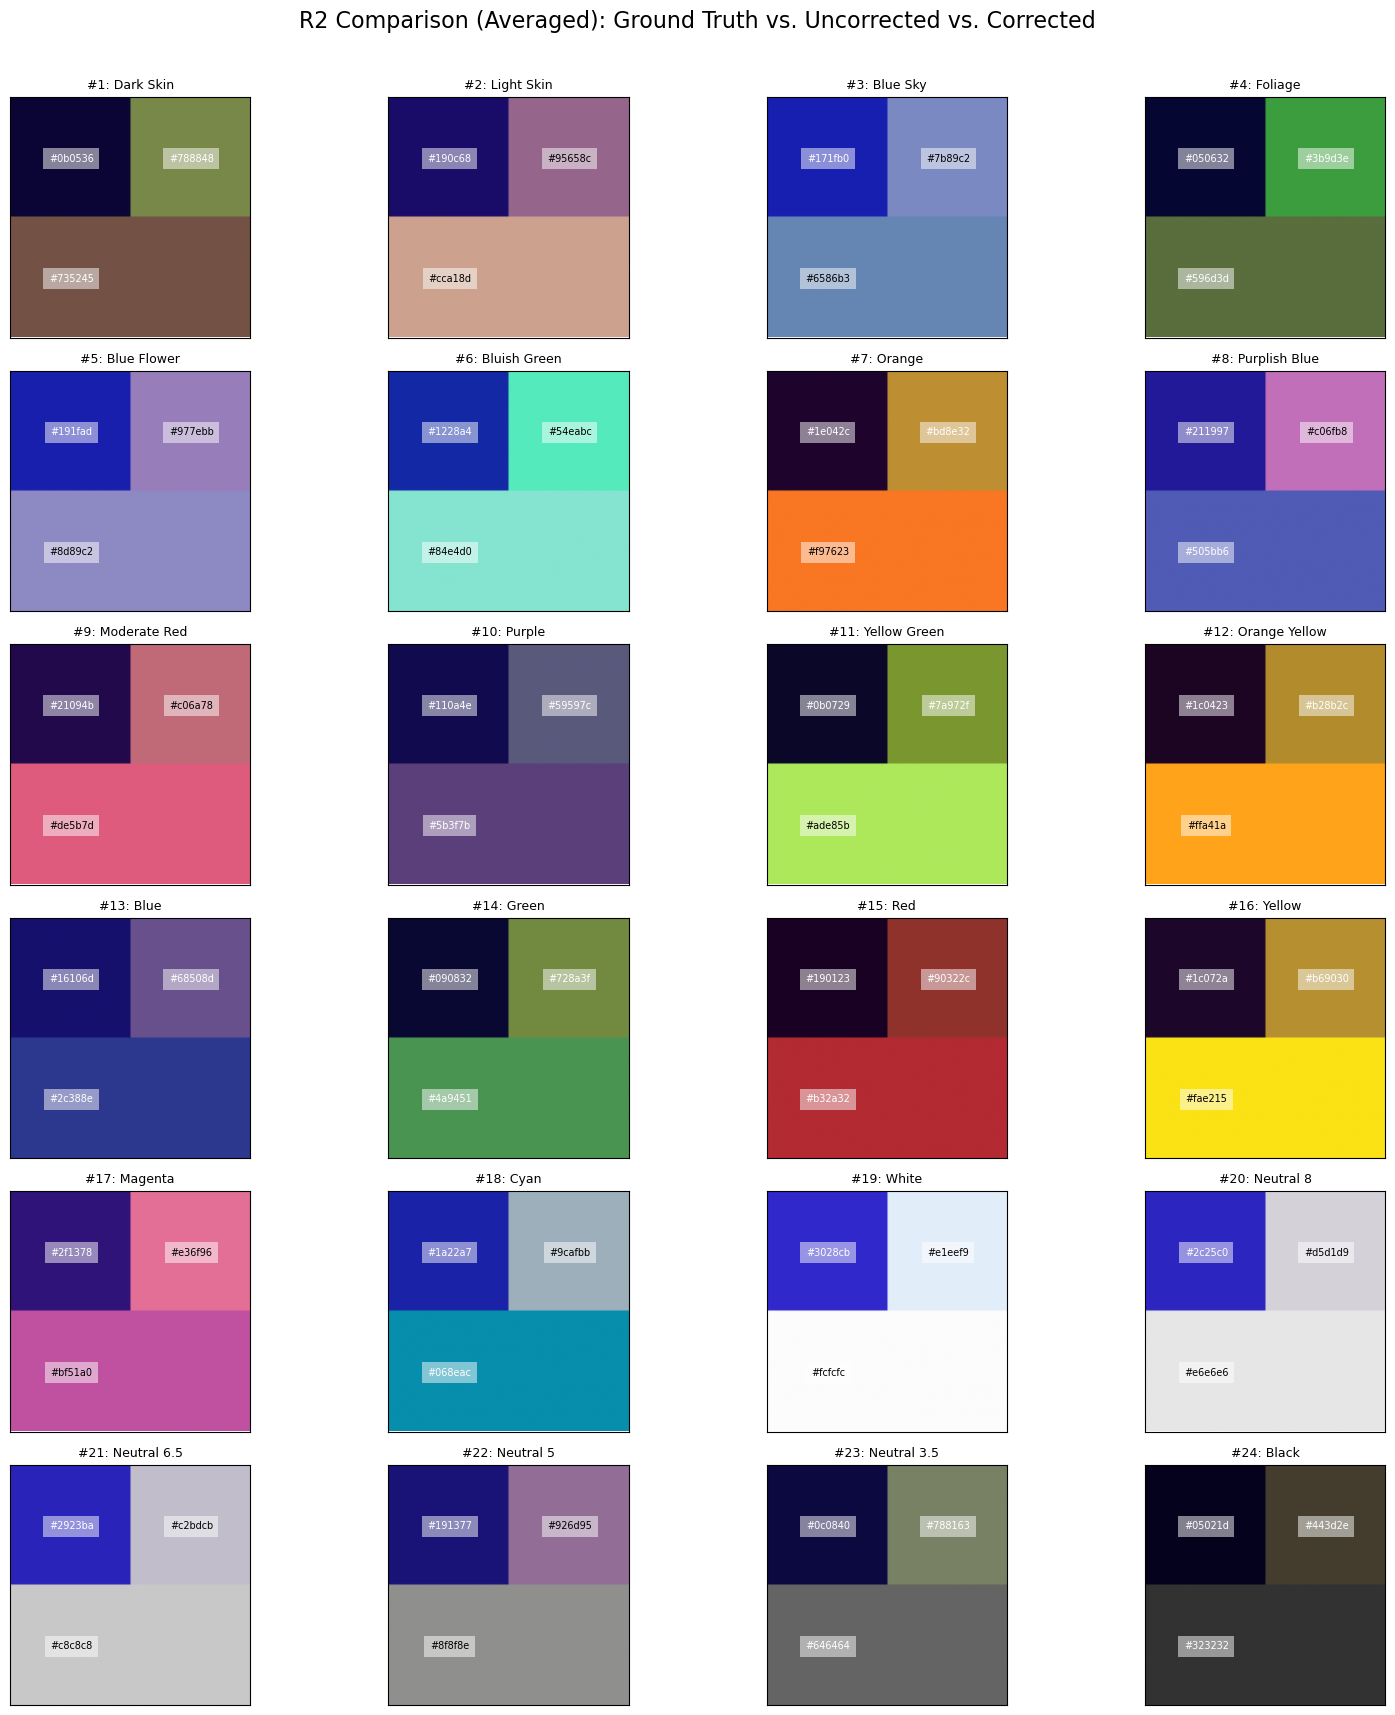

Plotting 24 unique samples for radius r4.


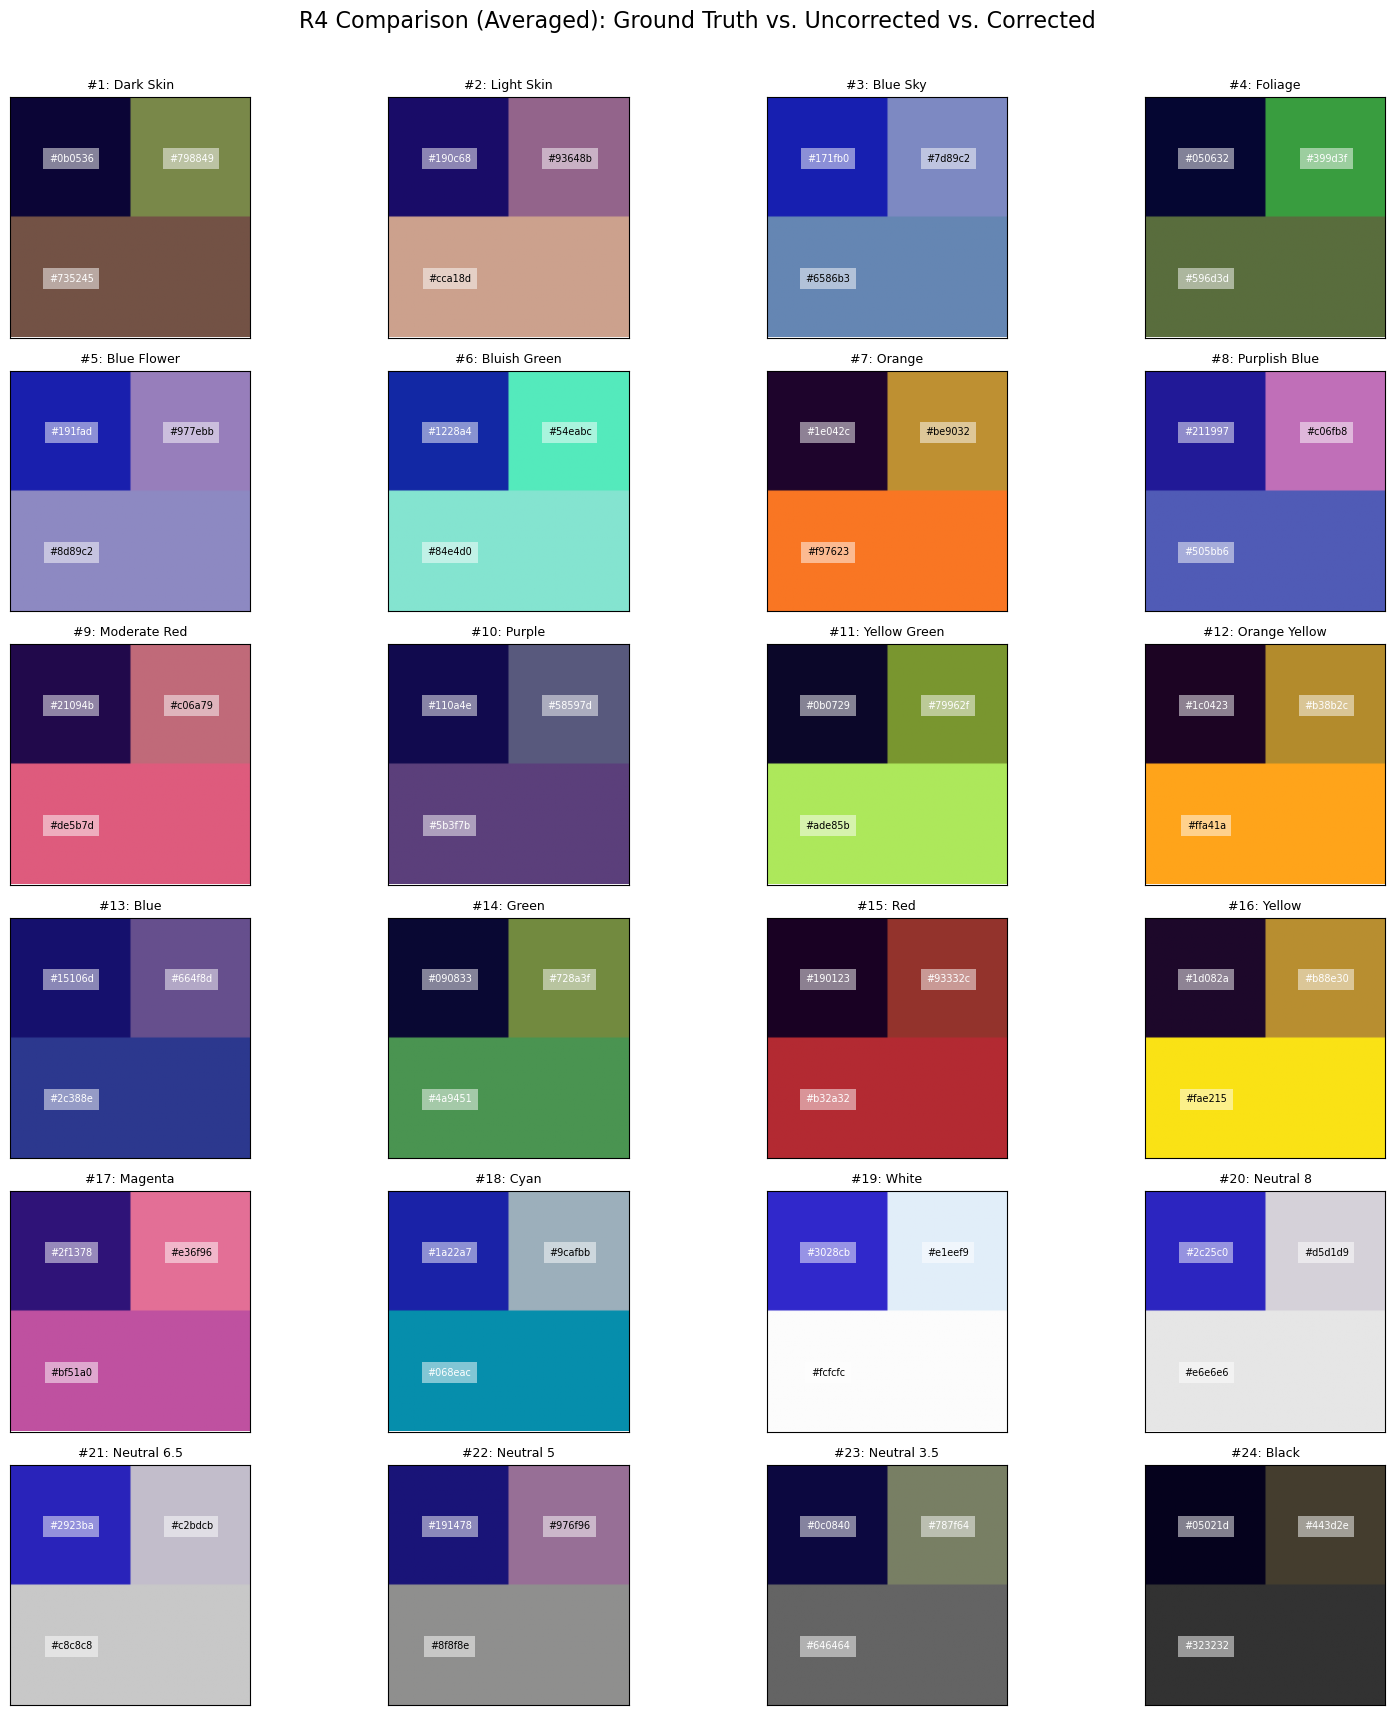

In [18]:
plotAllRadius(df_final_comparison)
# Not visually clear for human's eyes. But the MSE has decreased. A meticulous analysis would yield this is better.

In [19]:
def convert_rgb_to_hsv(r, g, b):
    # Normalize RGB values to 0-1 range
    normalized_rgb = np.array([r, g, b]) / 255.0
    # Convert to HSV
    hsv = rgb_to_hsv(normalized_rgb)
    return hsv[0], hsv[1], hsv[2]

# Apply to Ground Truth colors
def df_HSV(df_final_comparison):
  df_final_comparison[['gt__H', 'gt__S', 'gt__V']] = df_final_comparison.apply(
      lambda row: convert_rgb_to_hsv(row['gt__R'], row['gt__G'], row['gt__B']),
      axis=1,
      result_type='expand'
  )

  # Apply to Uncorrected colors
  df_final_comparison[['uncorr_H', 'uncorr_S', 'uncorr_V']] = df_final_comparison.apply(
      lambda row: convert_rgb_to_hsv(row['color_r2_R'], row['color_r2_G'], row['color_r2_B']),
      axis=1,
      result_type='expand'
  )

  # Apply to Corrected colors
  df_final_comparison[['corr_H', 'corr_S', 'corr_V']] = df_final_comparison.apply(
      lambda row: convert_rgb_to_hsv(row['correction_r2_R'], row['correction_r2_G'], row['correction_r2_B']),
      axis=1,
      result_type='expand'
  )

  # Calculate H_error considering the circular nature of Hue (normalized to 0-1)
  h_diff_uncorr = np.abs(df_final_comparison['uncorr_H'] - df_final_comparison['gt__H'])
  df_final_comparison['H_error_uncorr'] = np.minimum(h_diff_uncorr, 1 - h_diff_uncorr)

  h_diff_corr = np.abs(df_final_comparison['corr_H'] - df_final_comparison['gt__H'])
  df_final_comparison['H_error_corr'] = np.minimum(h_diff_corr, 1 - h_diff_corr)

  df_final_comparison['S_error_uncorr'] = df_final_comparison['uncorr_S'] - df_final_comparison['gt__S']
  df_final_comparison['S_error_corr'] = df_final_comparison['corr_S'] - df_final_comparison['gt__S']

  df_final_comparison['V_error_uncorr'] = df_final_comparison['uncorr_V'] - df_final_comparison['gt__V']
  df_final_comparison['V_error_corr'] = df_final_comparison['corr_V'] - df_final_comparison['gt__V']
  return df_final_comparison

In [20]:
# Define the HSV components to plot
def plotHSV(df_final_comparison):
  hsv_components = ['H', 'S', 'V']

  for component in hsv_components:
      plt.figure(figsize=(10, 6))

      # Uncorrected error column name
      uncorr_error_col = f'{component}_error_uncorr'
      # Corrected error column name
      corr_error_col = f'{component}_error_corr'

      # Plot uncorrected error distribution
      sns.kdeplot(x=df_final_comparison[uncorr_error_col],
              fill=True,
              color='blue',
              label='Uncorrected',
              alpha=0.2,
              common_norm=False)

      # Plot corrected error distribution
      #sns.histplot(df_final_comparison[corr_error_col], kde=True, color='red', label='Corrected', alpha=0.6, stat='density', common_norm=False)

      sns.kdeplot(x=df_final_comparison[corr_error_col],
              fill=True,
              color='red',
              label='Corrected',
              alpha=0.2,
              common_norm=False)

      # Calculate mean and standard deviation for both distributions
      mean_uncorr = df_final_comparison[uncorr_error_col].mean()
      std_uncorr = df_final_comparison[uncorr_error_col].std()

      mean_corr = df_final_comparison[corr_error_col].mean()
      std_corr = df_final_comparison[corr_error_col].std()

      # Add text annotations for mean and std dev
      plt.axvline(mean_uncorr, color='blue', linestyle='dashed', linewidth=1)
      plt.text(mean_uncorr + 0.01, plt.ylim()[1]*0.9, f'Mean Uncorr: {mean_uncorr:.3f}', color='blue', fontsize=10)
      plt.text(mean_uncorr + 0.01, plt.ylim()[1]*0.85, f'Std Uncorr: {std_uncorr:.3f}', color='blue', fontsize=10)

      plt.axvline(mean_corr, color='red', linestyle='dashed', linewidth=1)
      plt.text(mean_corr + 0.01, plt.ylim()[1]*0.75, f'Mean Corr: {mean_corr:.3f}', color='red', fontsize=10)
      plt.text(mean_corr + 0.01, plt.ylim()[1]*0.7, f'Std Corr: {std_corr:.3f}', color='red', fontsize=10)

      # Set title and labels
      plt.title(f'Distribution of {component} Error: Uncorrected vs. Corrected')
      plt.xlabel('Error Value')
      plt.ylabel('Density')
      plt.legend()
      plt.grid(True, linestyle='--', alpha=0.7)
      plt.tight_layout()
      plt.show()


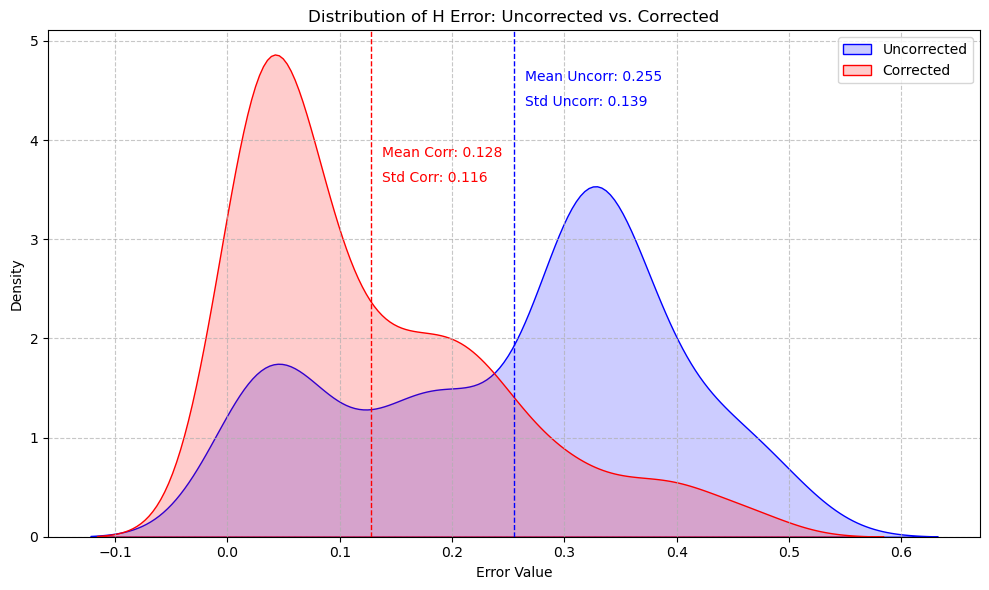

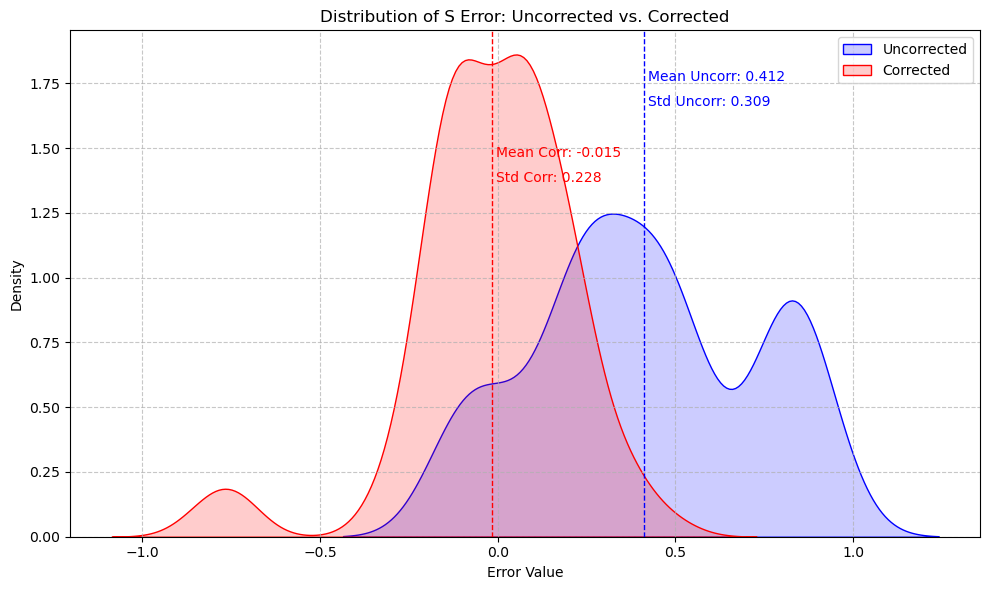

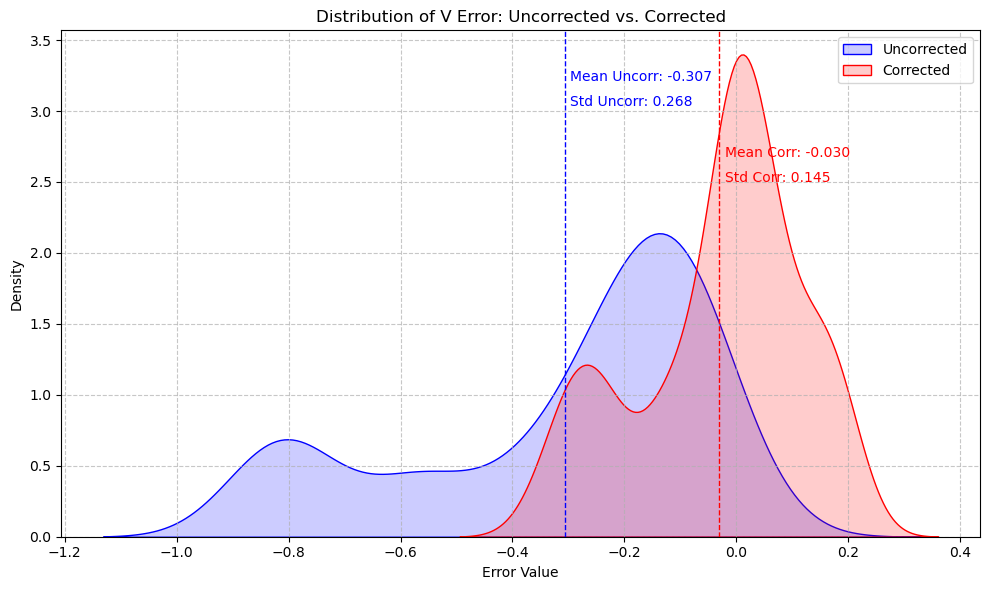

In [21]:
df = df_HSV(df)
plotHSV(df)

In [22]:
ref_r_white = 184.5
ref_g_white = 171.8
ref_b_white = 146.5

# Apply the correction to the color_r4 values
corrected_r_white_scaling, corrected_g_white_scaling, corrected_b_white_scaling = correctByFixedWhiteScaling(
    ref_r_white, ref_g_white, ref_b_white,
    df['color_r4_R'].values,
    df['color_r4_G'].values,
    df['color_r4_B'].values
)

# Calculate MSE for each channel
mse_r_white_scaling = mean_squared_error(df['gt__R'].values, corrected_r_white_scaling)
mse_g_white_scaling = mean_squared_error(df['gt__G'].values, corrected_g_white_scaling)
mse_b_white_scaling = mean_squared_error(df['gt__B'].values, corrected_b_white_scaling)

# Calculate average MSE
avg_mse_white_scaling = (mse_r_white_scaling + mse_g_white_scaling + mse_b_white_scaling) / 3

print("Fixed White Scaling MSE:")
print(f"  R Channel MSE: {mse_r_white_scaling:.2f}")
print(f"  G Channel MSE: {mse_g_white_scaling:.2f}")
print(f"  B Channel MSE: {mse_b_white_scaling:.2f}")
print(f"  Average MSE: {avg_mse_white_scaling:.2f}")


print("\nIndividually Optimized Polynomial Correction MSE:")
print(f"  R Channel MSE: {best_result['mse_r']:.2f}")
print(f"  G Channel MSE: {best_result['mse_g']:.2f}")
print(f"  B Channel MSE: {best_result['mse_b']:.2f}")
print(f"  Average MSE: {best_result['avg_mse']:.2f}")

Fixed White Scaling MSE:
  R Channel MSE: 17263.55
  G Channel MSE: 15373.12
  B Channel MSE: 1956.21
  Average MSE: 11530.96

Individually Optimized Polynomial Correction MSE:
  R Channel MSE: 2947.63
  G Channel MSE: 1508.56
  B Channel MSE: 227.76
  Average MSE: 1561.32


## So, applying polynomials to correct R, G, B are better than using scaling, which is a linear term.


## Method 2: Using Matrix Correction:  
## [correction_r2_R    correction_r2_G   correction_r2_B]^T
## = [3 x 3 matrix] * [color_r2_R   color_r2_G   color_r2_B]^T
## Our task: Learn 9 entries of the 3 x 3 matrix.
## Conclusion: Compare with Fixed Scaling Method

In [23]:
def _apply_matrix_transform(r, g, b, matrix):
    """
    Applies a 3x3 transformation matrix to RGB values without clipping.
    r, g, b can be scalars or NumPy arrays.
    """
    # Ensure r, g, b are numpy arrays for consistent matrix multiplication
    r_arr = np.atleast_1d(r)
    g_arr = np.atleast_1d(g)
    b_arr = np.atleast_1d(b)

    # Stack RGB into a 3xN array (or 3x1 if scalars)
    rgb_stacked = np.vstack([r_arr, g_arr, b_arr])

    # Perform matrix multiplication
    corrected_rgb_stacked = np.dot(matrix, rgb_stacked)

    # Return corrected R, G, B as separate arrays (or scalars if original inputs were)
    if r_arr.ndim == 0:
        return corrected_rgb_stacked[0][0], corrected_rgb_stacked[1][0], corrected_rgb_stacked[2][0]
    return corrected_rgb_stacked[0], corrected_rgb_stacked[1], corrected_rgb_stacked[2]

def correctByMatrix(r, g, b, matrix):
    """
    Applies a 3x3 transformation matrix to RGB values and clips the results to [0, 255].
    r, g, b can be scalars or NumPy arrays.
    """
    corr_r, corr_g, corr_b = _apply_matrix_transform(r, g, b, matrix)

    # Clip the resulting corrected R, G, B values to the range [0, 255]
    corr_r_clipped = np.clip(corr_r, 0, 255).astype(int)
    corr_g_clipped = np.clip(corr_g, 0, 255).astype(int)
    corr_b_clipped = np.clip(corr_b, 0, 255).astype(int)

    return corr_r_clipped, corr_g_clipped, corr_b_clipped

def calculateMatrixLoss(flat_matrix_elements, measured_r, measured_g, measured_b, gt_r, gt_g, gt_b):
    """
    Loss function for optimizing a 3x3 transformation matrix.
    """
    matrix = flat_matrix_elements.reshape(3, 3)
    corr_r_unclipped, corr_g_unclipped, corr_b_unclipped = _apply_matrix_transform(
        measured_r, measured_g, measured_b, matrix
    )

    # Calculate the Mean Squared Error (MSE) for each channel
    mse_r = mean_squared_error(gt_r, corr_r_unclipped)
    mse_g = mean_squared_error(gt_g, corr_g_unclipped)
    mse_b = mean_squared_error(gt_b, corr_b_unclipped)

    # Average MSE across channels
    total_mse = (mse_r + mse_g + mse_b) / 3.0

    # Add a boundary_penalty that penalizes values outside the [0, 255] range
    boundary_penalty_r = np.mean((corr_r_unclipped < 0) | (corr_r_unclipped > 255)) * 1000
    boundary_penalty_g = np.mean((corr_g_unclipped < 0) | (corr_g_unclipped > 255)) * 1000
    boundary_penalty_b = np.mean((corr_b_unclipped < 0) | (corr_b_unclipped > 255)) * 1000
    boundary_penalty = boundary_penalty_r + boundary_penalty_g + boundary_penalty_b

    # Add a reg_penalty to penalize large matrix coefficients
    reg_penalty = 0.001 * np.sum(flat_matrix_elements**2)

    # Return the sum of the MSE (average across channels), boundary penalty, and regularization penalty.
    return total_mse + boundary_penalty + reg_penalty

def get_identity_matrix_flat():
    """
    Returns a 1D NumPy array representing a flattened 3x3 identity matrix.
    This will serve as an initial guess for the optimization.
    """
    return np.identity(3).flatten()

print("Matrix correction and optimization functions defined.")

Matrix correction and optimization functions defined.


In [24]:
measured_r = df['color_r4_R'].values
measured_g = df['color_r4_G'].values
measured_b = df['color_r4_B'].values

gt_r = df['gt__R'].values
gt_g = df['gt__G'].values
gt_b = df['gt__B'].values

print("Extracted measured and ground truth RGB values.")

Extracted measured and ground truth RGB values.


In [25]:
initial_guess = get_identity_matrix_flat()
bounds = [(-5, 5)] * 9

# Use partial to pass fixed arguments to the loss function
loss_func_partial = partial(
    calculateMatrixLoss,
    measured_r=measured_r,
    measured_g=measured_g,
    measured_b=measured_b,
    gt_r=gt_r,
    gt_g=gt_g,
    gt_b=gt_b
)

# Optimize using scipy.optimize.minimize
print("Optimizing 3x3 matrix...")
result = minimize(
    loss_func_partial,
    initial_guess,
    method='L-BFGS-B', # L-BFGS-B supports bounds
    bounds=bounds,
    options={'maxiter': 1000, 'ftol': 1e-8}
)

# Reshape the optimized 1D array of coefficients back into a 3x3 NumPy array
optimal_matrix = result.x.reshape(3, 3)

print("\nOptimization complete.")
print("Optimal 3x3 Transformation Matrix:")
print(optimal_matrix)

Optimizing 3x3 matrix...

Optimization complete.
Optimal 3x3 Transformation Matrix:
[[ 5.         -4.78586091  0.89115386]
 [ 3.14148678  3.05886247 -0.12457459]
 [ 0.01918178 -1.45540712  1.45155071]]


In [26]:
corrected_r_matrix, corrected_g_matrix, corrected_b_matrix = correctByMatrix(
    df['color_r4_R'].values,
    df['color_r4_G'].values,
    df['color_r4_B'].values,
    optimal_matrix
)

df['correction_r4_R_matrix'] = corrected_r_matrix
df['correction_r4_G_matrix'] = corrected_g_matrix
df['correction_r4_B_matrix'] = corrected_b_matrix

print("Applied matrix correction and stored results in new columns.")

Applied matrix correction and stored results in new columns.


In [27]:
mse_r_matrix_correction = mean_squared_error(df['gt__R'].values, df['correction_r4_R_matrix'].values)
mse_g_matrix_correction = mean_squared_error(df['gt__G'].values, df['correction_r4_G_matrix'].values)
mse_b_matrix_correction = mean_squared_error(df['gt__B'].values, df['correction_r4_B_matrix'].values)

avg_mse_matrix_correction = (mse_r_matrix_correction + mse_g_matrix_correction + mse_b_matrix_correction) / 3
print("\n--- Comparative Summary of Correction Methods ---")

print("\n1. Fixed White Scaling:")
print(f"  R Channel MSE: {mse_r_white_scaling:.2f}")
print(f"  G Channel MSE: {mse_g_white_scaling:.2f}")
print(f"  B Channel MSE: {mse_b_white_scaling:.2f}")
print(f"  Average MSE: {avg_mse_white_scaling:.2f}")

print("\n2. Individually Optimized Polynomial Correction:")
print(f"  R Channel MSE: {best_result['mse_r']:.2f}")
print(f"  G Channel MSE: {best_result['mse_g']:.2f}")
print(f"  B Channel MSE: {best_result['mse_b']:.2f}")
print(f"  Average MSE: {best_result['avg_mse']:.2f}")

print("\n3. Matrix Correction:")
print(f"  R Channel MSE: {mse_r_matrix_correction:.2f}")
print(f"  G Channel MSE: {mse_g_matrix_correction:.2f}")
print(f"  B Channel MSE: {mse_b_matrix_correction:.2f}")
print(f"  Average MSE: {avg_mse_matrix_correction:.2f}")


--- Comparative Summary of Correction Methods ---

1. Fixed White Scaling:
  R Channel MSE: 17263.55
  G Channel MSE: 15373.12
  B Channel MSE: 1956.21
  Average MSE: 11530.96

2. Individually Optimized Polynomial Correction:
  R Channel MSE: 2947.63
  G Channel MSE: 1508.56
  B Channel MSE: 227.76
  Average MSE: 1561.32

3. Matrix Correction:
  R Channel MSE: 3868.47
  G Channel MSE: 4294.32
  B Channel MSE: 397.92
  Average MSE: 2853.57


## Method 3: Using Multiple Input: correction_r2 = f(color_r2, pitch, roll)
## Our task: Learn the coefficient of f (linear for now).
## Conclusion: Compare with Fixed Scaling Method

In [28]:
def correctByMultiInputModel(measured_r, measured_g, measured_b, pitch, roll, coeffs):
  # Ensure all inputs are NumPy arrays
  measured_r = np.asarray(measured_r)
  measured_g = np.asarray(measured_g)
  measured_b = np.asarray(measured_b)
  pitch = np.asarray(pitch)
  roll = np.asarray(roll)
  coeffs = np.asarray(coeffs)

  # Each row corresponds to an output channel (R, G, B)
  # Each column corresponds to an input feature: [intercept, R_in, G_in, B_in, Pitch, Roll]
  coeffs_matrix = coeffs.reshape(3, 6)

  # Create an input_features matrix (N x 6)
  # Columns: [1, measured_r, measured_g, measured_b, pitch, roll]
  input_features = np.vstack([
      np.ones_like(measured_r), # Intercept term
      measured_r,
      measured_g,
      measured_b,
      pitch,
      roll
  ]).T # Transpose to get N rows x 6 features

  # Perform matrix multiplication to calculate corrected RGB values
  # coeffs_matrix (3x6) @ input_features.T (6xN) = corrected_rgb_unclipped (3xN)
  corrected_rgb_unclipped = coeffs_matrix @ input_features.T

  # Extract corrected R, G, B arrays
  corrected_r_unclipped = corrected_rgb_unclipped[0]
  corrected_g_unclipped = corrected_rgb_unclipped[1]
  corrected_b_unclipped = corrected_rgb_unclipped[2]

  # Clip the corrected values to the range [0, 255] and convert to integer
  corrected_r_clipped = np.clip(corrected_r_unclipped, 0, 255).astype(int)
  corrected_g_clipped = np.clip(corrected_g_unclipped, 0, 255).astype(int)
  corrected_b_clipped = np.clip(corrected_b_unclipped, 0, 255).astype(int)

  return corrected_r_clipped, corrected_g_clipped, corrected_b_clipped

print("correctByMultiInputModel function defined.")

correctByMultiInputModel function defined.


In [29]:
measured_r_multi = df['color_r4_R'].values
measured_g_multi = df['color_r4_G'].values
measured_b_multi = df['color_r4_B'].values

pitch_multi = df['pitch'].values
roll_multi = df['roll'].values

gt_r_multi = df['gt__R'].values
gt_g_multi = df['gt__G'].values
gt_b_multi = df['gt__B'].values

print("Extracted measured RGB, sensor data (pitch, roll), and ground truth RGB values for multi-input model.")

Extracted measured RGB, sensor data (pitch, roll), and ground truth RGB values for multi-input model.


In [30]:
def _apply_multi_input_model_unclipped(measured_r, measured_g, measured_b, pitch, roll, coeffs):
    # Ensure all inputs are NumPy arrays
    measured_r = np.asarray(measured_r)
    measured_g = np.asarray(measured_g)
    measured_b = np.asarray(measured_b)
    pitch = np.asarray(pitch)
    roll = np.asarray(roll)
    coeffs = np.asarray(coeffs)

    # Reshape the 1D coeffs array into a 3x6 matrix
    coeffs_matrix = coeffs.reshape(3, 6)

    # Create an input_features matrix (N x 6)
    input_features = np.vstack([
        np.ones_like(measured_r), # Intercept term
        measured_r,
        measured_g,
        measured_b,
        pitch,
        roll
    ]).T # Transpose to get N rows x 6 features

    # Perform matrix multiplication to calculate corrected RGB values
    corrected_rgb_unclipped = coeffs_matrix @ input_features.T

    # Extract corrected R, G, B arrays
    corrected_r_unclipped = corrected_rgb_unclipped[0]
    corrected_g_unclipped = corrected_rgb_unclipped[1]
    corrected_b_unclipped = corrected_rgb_unclipped[2]

    return corrected_r_unclipped, corrected_g_unclipped, corrected_b_unclipped

def calculateMultiInputLoss(flat_coeffs, measured_r, measured_g, measured_b, pitch, roll, gt_r, gt_g, gt_b):
    # Use the unclipped version of the model for loss calculation
    corr_r_unclipped, corr_g_unclipped, corr_b_unclipped = _apply_multi_input_model_unclipped(
        measured_r, measured_g, measured_b, pitch, roll, flat_coeffs
    )

    # Calculate MSE for each channel
    mse_r = mean_squared_error(gt_r, corr_r_unclipped)
    mse_g = mean_squared_error(gt_g, corr_g_unclipped)
    mse_b = mean_squared_error(gt_b, corr_b_unclipped)

    # Average MSE across channels
    total_mse = (mse_r + mse_g + mse_b) / 3.0

    # Implement boundary penalty
    # Penalize values outside [0, 255] range
    boundary_penalty = (
        np.mean((corr_r_unclipped < 0) | (corr_r_unclipped > 255)) +
        np.mean((corr_g_unclipped < 0) | (corr_g_unclipped > 255)) +
        np.mean((corr_b_unclipped < 0) | (corr_b_unclipped > 255))
    ) * 1000 # Scaling factor for boundary penalty

    # Implement regularization penalty (L2 regularization on coefficients)
    reg_penalty = 0.001 * np.sum(flat_coeffs**2)

    # Return the total loss
    return total_mse + boundary_penalty + reg_penalty

print("`_apply_multi_input_model_unclipped` and `calculateMultiInputLoss` functions defined.")

`_apply_multi_input_model_unclipped` and `calculateMultiInputLoss` functions defined.


In [31]:
import numpy as np
from scipy.optimize import minimize
from functools import partial

initial_guess = np.array([
    0, 1, 0, 0, 0, 0,
    0, 0, 1, 0, 0, 0,
    0, 0, 0, 1, 0, 0
], dtype=float)

# 2. Define bounds for the 18 coefficients
bounds = [(-5.0, 5.0)] * 18

# 3. Create a partial function for calculateMultiInputLoss
loss_func_partial_multi_input = partial(
    calculateMultiInputLoss,
    measured_r=measured_r_multi,
    measured_g=measured_g_multi,
    measured_b=measured_b_multi,
    pitch=pitch_multi,
    roll=roll_multi,
    gt_r=gt_r_multi,
    gt_g=gt_g_multi,
    gt_b=gt_b_multi
)

# 4. Use scipy.optimize.minimize
print("Optimizing multi-input model coefficients...")
result_multi_input = minimize(
    loss_func_partial_multi_input,
    initial_guess,
    method='L-BFGS-B',
    bounds=bounds,
    options={'maxiter': 1000, 'ftol': 1e-8}
)

# 5. Reshape the optimized 1D array of coefficients back into a 3x6 matrix
optimal_multi_input_coeffs = result_multi_input.x.reshape(3, 6)

# 6. Print the optimal_multi_input_coeffs matrix
print("\nOptimization complete.")
print("Optimal Multi-Input Model Coefficients (3x6 matrix):")
print(optimal_multi_input_coeffs)


Optimizing multi-input model coefficients...



Optimization complete.
Optimal Multi-Input Model Coefficients (3x6 matrix):
[[ 5.          5.         -3.33644019  0.53891694  5.         -5.        ]
 [ 5.          2.8672368   4.28400691 -0.38323622  5.         -5.        ]
 [ 3.59982739 -0.24882331 -1.36746305  1.432561    3.2825092  -3.60154465]]


In [32]:
corrected_r_multi, corrected_g_multi, corrected_b_multi = correctByMultiInputModel(
    measured_r_multi,
    measured_g_multi,
    measured_b_multi,
    pitch_multi,
    roll_multi,
    optimal_multi_input_coeffs.flatten() # Flatten the 3x6 matrix back to 1D for the function
)

df['correction_r4_R_multi'] = corrected_r_multi
df['correction_r4_G_multi'] = corrected_g_multi
df['correction_r4_B_multi'] = corrected_b_multi

print("Applied multi-input model correction and stored results in new columns: 'correction_r4_R_multi', 'correction_r4_G_multi', 'correction_r4_B_multi'.")

Applied multi-input model correction and stored results in new columns: 'correction_r4_R_multi', 'correction_r4_G_multi', 'correction_r4_B_multi'.


In [33]:
mse_r_multi_input = mean_squared_error(df['gt__R'].values, df['correction_r4_R_multi'].values)
mse_g_multi_input = mean_squared_error(df['gt__G'].values, df['correction_r4_G_multi'].values)
mse_b_multi_input = mean_squared_error(df['gt__B'].values, df['correction_r4_B_multi'].values)

avg_mse_multi_input = (mse_r_multi_input + mse_g_multi_input + mse_b_multi_input) / 3

print("\nMulti-Input Correction MSE:")
print(f"  R Channel MSE: {mse_r_multi_input:.2f}")
print(f"  G Channel MSE: {mse_g_multi_input:.2f}")
print(f"  B Channel MSE: {mse_b_multi_input:.2f}")
print(f"  Average MSE: {avg_mse_multi_input:.2f}")

print("\n--- Comparative Summary of All Correction Methods ---")

print("\n1. Fixed White Scaling:")
print(f"  R Channel MSE: {mse_r_white_scaling:.2f}")
print(f"  G Channel MSE: {mse_g_white_scaling:.2f}")
print(f"  B Channel MSE: {mse_b_white_scaling:.2f}")
print(f"  Average MSE: {avg_mse_white_scaling:.2f}")

print("\n2. Individually Optimized Polynomial Correction:")
print(f"  R Channel MSE: {best_result['mse_r']:.2f}")
print(f"  G Channel MSE: {best_result['mse_g']:.2f}")
print(f"  B Channel MSE: {best_result['mse_b']:.2f}")
print(f"  Average MSE: {best_result['avg_mse']:.2f}")

print("\n3. Matrix Correction:")
print(f"  R Channel MSE: {mse_r_matrix_correction:.2f}")
print(f"  G Channel MSE: {mse_g_matrix_correction:.2f}")
print(f"  B Channel MSE: {mse_b_matrix_correction:.2f}")
print(f"  Average MSE: {avg_mse_matrix_correction:.2f}")

print("\n4. Multi-Input Correction:")
print(f"  R Channel MSE: {mse_r_multi_input:.2f}")
print(f"  G Channel MSE: {mse_g_multi_input:.2f}")
print(f"  B Channel MSE: {mse_b_multi_input:.2f}")
print(f"  Average MSE: {avg_mse_multi_input:.2f}")


Multi-Input Correction MSE:
  R Channel MSE: 3367.08
  G Channel MSE: 3819.02
  B Channel MSE: 359.35
  Average MSE: 2515.15

--- Comparative Summary of All Correction Methods ---

1. Fixed White Scaling:
  R Channel MSE: 17263.55
  G Channel MSE: 15373.12
  B Channel MSE: 1956.21
  Average MSE: 11530.96

2. Individually Optimized Polynomial Correction:
  R Channel MSE: 2947.63
  G Channel MSE: 1508.56
  B Channel MSE: 227.76
  Average MSE: 1561.32

3. Matrix Correction:
  R Channel MSE: 3868.47
  G Channel MSE: 4294.32
  B Channel MSE: 397.92
  Average MSE: 2853.57

4. Multi-Input Correction:
  R Channel MSE: 3367.08
  G Channel MSE: 3819.02
  B Channel MSE: 359.35
  Average MSE: 2515.15
